In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [2]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


# TAKE SUBSAMPLE OF DATA FOR COMPUTATION ISSUES (TODO: DELETE THIS LATER)

In [3]:
df = df.sample(frac = 0.05)

# Model Preprocessing: Encode Features from categorical to numerical

In [4]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# Preview
print(cat_columns)

float64    87
object     13
int64       1
dtype: int64
['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


### Deleted irrelevant categorical features
Delete categorical features that are not relevant for the Modelling or contain too many realization so that encoding them would be infeasible.

In [5]:
# Keep: disbursement_method, home_ownership, pymnt_plan
CAT_COLS_TO_KEEP = ["disbursement_method", "home_ownership", "pymnt_plan"]
CAT_COLS_TO_DROP = [col for col in cat_columns if col not in CAT_COLS_TO_KEEP]

print(f"Categorical Columns to drop: {CAT_COLS_TO_DROP}\n")
print(f"Shape of df before columns drop: {df.shape}")
# Drop irrelevant categorical features
df.drop(CAT_COLS_TO_DROP, axis=1, inplace=True)
print(f"Shape of df after columns drop: {df.shape}")

Categorical Columns to drop: ['term', 'grade', 'sub_grade', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']

Shape of df before columns drop: (67266, 101)
Shape of df after columns drop: (67266, 91)


In [6]:
print(df.dtypes.value_counts())

float64    87
object      3
int64       1
dtype: int64


In [7]:
# Testing: One-Hot-Encoding
#df_ohe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
#df_ohe.dtypes.value_counts()

In [8]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=CAT_COLS_TO_KEEP)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    87
int64       7
dtype: int64

In [9]:
# Convert all values to float
df_binary = df_binary.astype(float)
df_binary.dtypes.value_counts()
#df_ohe = df_ohe.astype(float)

float64    94
dtype: int64

## Preview preprocessed dataframe:

In [10]:
df_binary.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,home_ownership_0,home_ownership_1,home_ownership_2,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method_0,disbursement_method_1
1021950,8000.0,8000.0,8000.0,5.32,240.92,NaN,0.0,0.0,1.0,75000.0,...,100.0,0.0,0.0,0.0,188367.0,74441.0,108700.0,76667.0,0.0,1.0
1340891,6000.0,6000.0,6000.0,13.53,203.70,8.0,0.0,0.0,1.0,55000.0,...,100.0,100.0,0.0,0.0,33044.0,17787.0,8300.0,22344.0,0.0,1.0
370758,25000.0,25000.0,25000.0,6.92,771.02,10.0,0.0,0.0,1.0,63300.0,...,98.4,7.1,0.0,0.0,393614.0,39851.0,187900.0,13814.0,0.0,1.0
1925767,30000.0,30000.0,30000.0,21.97,828.06,2.0,0.0,0.0,1.0,131500.0,...,NaN,25.0,0.0,0.0,NaN,107057.0,35707.0,NaN,0.0,1.0
1630948,5275.0,5275.0,5250.0,13.80,122.20,1.0,0.0,0.0,1.0,90000.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0
412393,16000.0,16000.0,16000.0,12.99,539.03,4.0,0.0,1.0,0.0,75000.0,...,96.7,66.7,0.0,0.0,302523.0,36759.0,8800.0,34147.0,0.0,1.0
237539,22000.0,22000.0,22000.0,6.24,671.68,2.0,0.0,0.0,1.0,105000.0,...,100.0,0.0,0.0,0.0,45245.0,18084.0,27300.0,13045.0,0.0,1.0
1152117,21325.0,21325.0,21325.0,14.49,501.63,4.0,0.0,1.0,1.0,95000.0,...,100.0,60.0,0.0,0.0,155168.0,148971.0,30400.0,121968.0,0.0,1.0
746131,21050.0,21050.0,21025.0,20.75,790.37,7.0,0.0,0.0,1.0,94000.0,...,100.0,50.0,0.0,0.0,429678.0,49660.0,14200.0,53291.0,0.0,1.0
1278879,35000.0,35000.0,35000.0,16.99,869.66,10.0,0.0,1.0,1.0,165000.0,...,100.0,33.3,0.0,0.0,157782.0,109957.0,94500.0,63282.0,0.0,1.0


# Create Balanced Data Set via Downsampling

0.0    53708
1.0    13558
Name: loan_status, dtype: int64
(67266, 94)


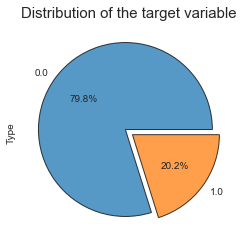

In [11]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.05, 0.05])
plt.show()

0.0    17625
1.0    13558
Name: loan_status, dtype: int64


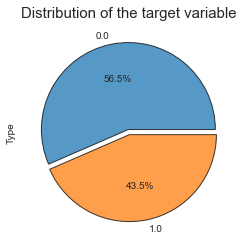

In [12]:
# Downsampling
loan_status_0 = df_binary[df_binary["loan_status"] == 0.0]
loan_status_1  = df_binary[df_binary["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.03, 0.03])
plt.show()

# Data Imputation

In [13]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,home_ownership_0,home_ownership_1,home_ownership_2,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method_0,disbursement_method_1
276281,15000.0,15000.0,15000.0,11.53,494.86,0.0,0.0,1.0,1.0,120000.0,...,90.0,50.0,0.0,0.0,11000.0,9679.0,5000.0,6000.0,0.0,1.0
384890,3600.0,3600.0,3600.0,13.66,122.45,6.0,0.0,1.0,0.0,21000.0,...,97.0,42.9,0.0,0.0,22600.0,13416.0,16000.0,0.0,0.0,1.0
1693074,21000.0,21000.0,21000.0,8.24,660.40,10.0,0.0,1.0,1.0,102500.0,...,96.2,100.0,0.0,0.0,130086.0,20883.0,18400.0,5401.0,0.0,1.0
658774,8000.0,8000.0,8000.0,9.49,256.23,6.0,0.0,0.0,1.0,65000.0,...,94.1,20.0,0.0,0.0,192405.0,39165.0,15800.0,50374.0,0.0,1.0
1858697,12475.0,12475.0,12475.0,16.29,440.38,3.0,0.0,0.0,1.0,37500.0,...,95.0,100.0,0.0,0.0,196237.0,102201.0,16700.0,81021.0,0.0,1.0


# Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [14]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (21828, 93)
Shape of X_test: (9355, 93)
Shape of y_train: (21828,)
Shape of y_test: (9355,)


# Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [15]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.076923,0.076923,0.100,0.649143,0.051583,0.5,0.0,0.0,1.0,0.003089,...,1.000000,0.000,0.0,0.0,0.003411,0.002850,0.009838,0.000000,0.0,1.0
1,0.487179,0.487179,0.500,0.325545,0.417594,0.9,0.0,1.0,1.0,0.012758,...,1.000000,0.875,0.0,0.0,0.005490,0.056416,0.093816,0.019770,0.0,1.0
2,0.307692,0.307692,0.325,0.036215,0.235558,1.0,0.0,1.0,1.0,0.009132,...,0.828571,0.000,0.0,0.0,0.003721,0.017440,0.091708,0.000000,0.0,1.0
3,0.051282,0.051282,0.075,0.299065,0.045565,0.3,0.0,0.0,1.0,0.003223,...,1.000000,1.000,0.0,0.0,0.002225,0.028001,0.032326,0.016564,0.0,1.0
4,0.230769,0.230769,0.250,0.221184,0.190879,0.7,0.0,0.0,1.0,0.011684,...,0.977143,1.000,0.0,0.0,0.023434,0.250834,0.056219,0.315240,0.0,1.0


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [16]:
# Fit Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

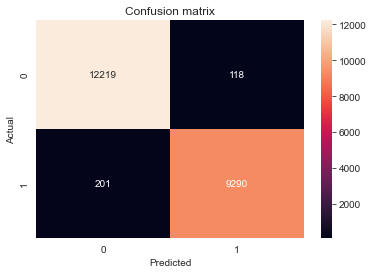

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     12337
         1.0       0.99      0.98      0.98      9491

    accuracy                           0.99     21828
   macro avg       0.99      0.98      0.99     21828
weighted avg       0.99      0.99      0.99     21828

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [17]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4: Compare different classification models

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [18]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=5000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC",SVC(kernel='rbf')))
models.append(("SVC",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name,model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=2)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

100%|██████████| 7/7 [00:36<00:00,  5.17s/it]

LogisticRegression 0.9810793476269013
DecisionTree 0.9866684991753711
RandomForest 0.991936961700568
BaggingCLF 0.9885468205973977
SVC 0.9825453545904343
SVC 0.9902877038665934
NeuronalNetwork 0.9741616272677295
CPU times: user 36.1 s, sys: 2.03 s, total: 38.2 s
Wall time: 36.3 s


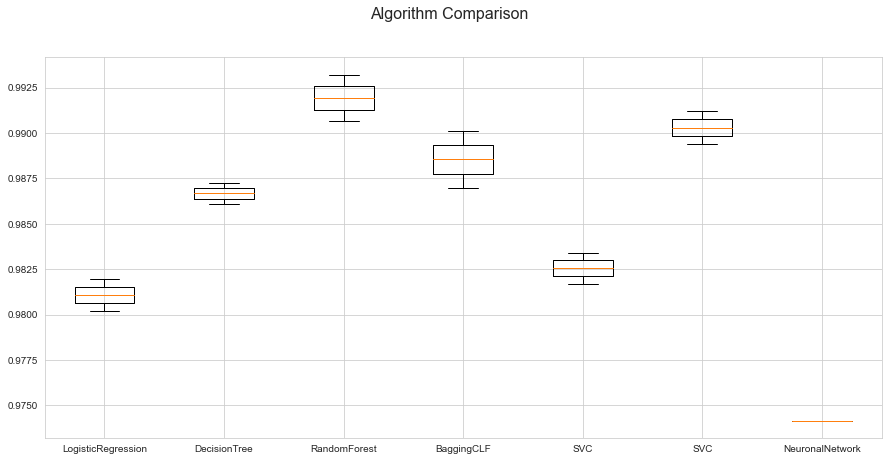

In [19]:
# Boxplot algorithm comparison
fig = plt.figure(figsize=(15,7))
fig.suptitle('Algorithm Comparison', size=16)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()